In [1]:
# imports from the pyfoomb package
import pyfoomb
print(f'Current package version of {pyfoomb.__name__}: {pyfoomb.__version__}')

from pyfoomb import BioprocessModel
from pyfoomb import ObservationFunction
from pyfoomb import Caretaker
from pyfoomb import Visualization
from pyfoomb import Measurement
from pyfoomb import ParameterMapper
from pyfoomb.utils import Helpers

C:\Users\hemmerich\AppData\Local\Continuum\miniconda3\envs\pyfoomb-dev\lib\site-packages\assimulo\solvers\odepack.py:701: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  N.array([[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],  # 5th order
Could not find GLIMDA.


Current package version of pyfoomb: 2.17.7


In [2]:
from matplotlib import pyplot
import numpy
import pandas
import time

# Set seed of random number generator for reproducibility
numpy.random.seed(666)

# Method `estimate_parallel_MC_sampling()`

This notebook demonstrates the use of the MC sampling version of the `estimate_parallel()` method, which is based on the parallelization capabilities provided by the `pygmo` package.

The idea of this method is to reduce the number of parallel islands in an archipelago, which allows to run several of such archipelagos in parallel (depending on the number of available cores).

Thus, it is possible to work on several MC samples in parallel to shorten the total runtime. This scales very nicely with the number of available cores. The two main factors for speed-up are number of cores and clock frequency of the individual cores.

### Some helper functions for this notebook

In [3]:
# Creates a noisy dataset, based on a forward simulation
def noisy_samples(simulations, samples=5, rel_err=0.05, abs_err=0.05, repetitions=3, with_errors=True):
    artifical_data = []
    
    # get joint time points
    t_all = Helpers.get_unique_timepoints(simulations)

    # iterate over simulations
    for simulation in simulations:
        
        _name = simulation.name
        _replicate_id = simulation.replicate_id
        _t_samples = numpy.random.choice(simulation.timepoints, size=samples, replace=False)
        _sample_idxs = numpy.in1d(simulation.timepoints, _t_samples)
        _timepoints = simulation.timepoints[_sample_idxs]
        _values = simulation.values[_sample_idxs]
        
        # generate random samples
        _rnd_values = [
            numpy.random.normal(loc=_values, scale=abs(_values*rel_err+abs_err)) 
            for _ in range(repetitions)
        ]
        
        # create new Measurement object
        _measurement = Measurement(
            name=_name, 
            replicate_id=_replicate_id,
            timepoints=_timepoints, 
            values=numpy.mean(_rnd_values, axis=0),
            errors=numpy.std(_rnd_values, ddof=1, axis=0) if with_errors else None,
        )
        artifical_data.append(_measurement)
        
    return artifical_data


def make_experiment(caretaker:Caretaker, tfinal:float, samples:int=3, show:bool=True):
    
    simulation = caretaker.simulate(t=tfinal)
    data = noisy_samples(caretaker.simulate(t=numpy.arange(tfinal*4)/4), samples=samples)
    if show:
        _ncols = len(set([_item.name for _item in simulation]))
        Visualization.show_kinetic_data(simulation, ncols=_ncols)
        _ncols = len(set([_item.name for _item in data]))
        Visualization.show_kinetic_data(data, ncols=_ncols)

    return data, simulation

# Bioprocess model


First, the bioprocess model is defined. This model is also used to generate some noisy artifical data to demonstrate the parameter estimation process.

In [4]:
# Defines the model class
class GrowthCoupledProduction(BioprocessModel):
        
    def specific_growth_rate_mu(self, t, y):
        P, S, X = y
        kS = self.model_parameters['kS']
        mu_max = self.model_parameters['mu_max']
        mu = mu_max * S / (kS + S)
        return mu
    
    def specific_production_rate_qP(self, t, y):
        P, S, X = y
        YPX = self.model_parameters['YPX']
        mu = self.specific_growth_rate_mu(t, y)
        qP = YPX * mu
        return qP
    
    def specific_substrate_consumption_rate_qS(self, t, y):
        P, S, X = y
        YXS = self.model_parameters['YXS']
        YPS = self.model_parameters['YPS']
        mu = self.specific_growth_rate_mu(t, y)
        qP = self.specific_production_rate_qP(t, y)
        qS = 1/YXS * mu + 1/YPS * qP
        return qS
    
    def rhs(self, t, y):
        
        # Unpacks the state vector. The states are alphabetically ordered.
        P, S, X = y

        # Calculate specific rates
        mu = self.specific_growth_rate_mu(t, y)
        qP = self.specific_production_rate_qP(t, y)
        qS = self.specific_substrate_consumption_rate_qS(t, y)

        # Calculate state derivatives
        dXdt = mu * X
        dSdt = -qS * X
        dPdt = qP * X
        
        return [dPdt, dSdt, dXdt]

    
model_parameters = {
    'kS' : 0.05,
    'mu_max' : 0.4,
    'YXS' : 0.6,
    'YPS' : 0.4,
    'YPX' : 0.2,
}     

initial_values = {
    'S0' : 20.0,
    'X0' : 0.01,
    'P0' : 0.0,
}

# Instantiates are caretaker with two replicate_ids
caretaker = Caretaker(
    bioprocess_model_class=GrowthCoupledProduction, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
)

# Save for later comparison
_pars_for_comp = caretaker._get_all_parameters()

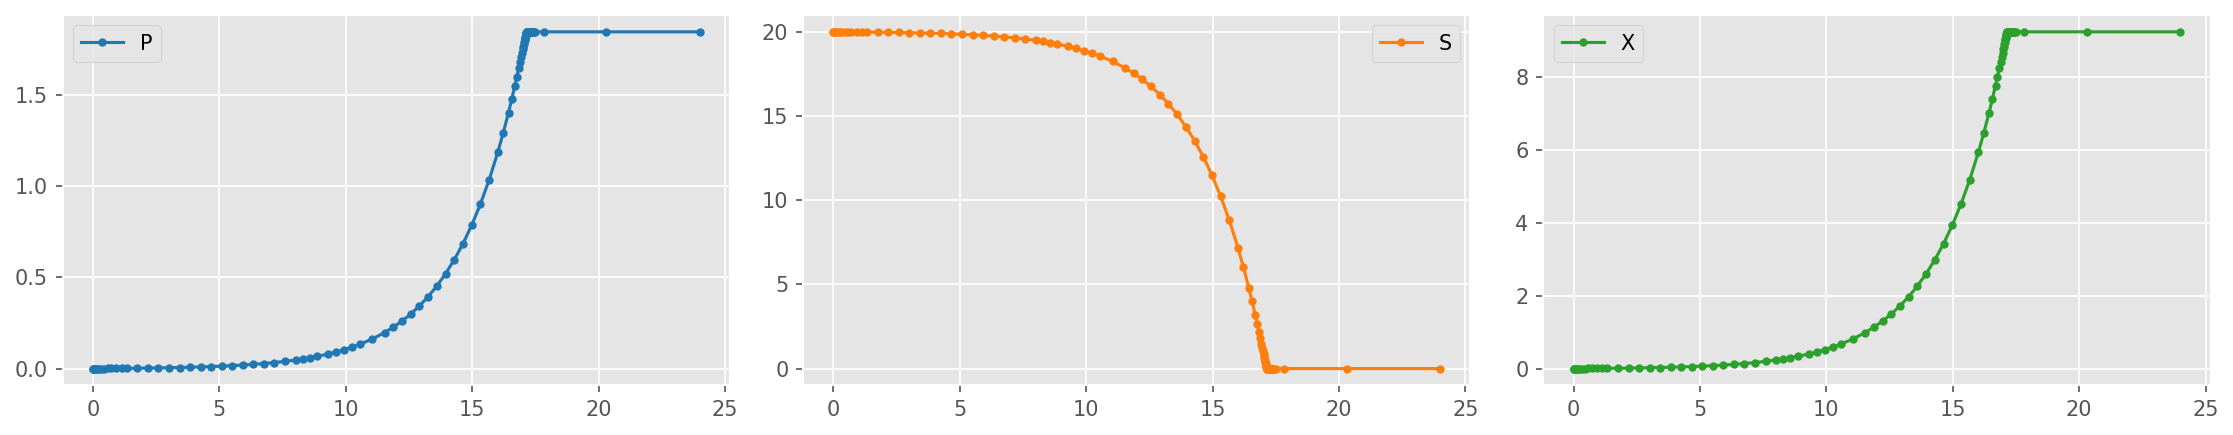

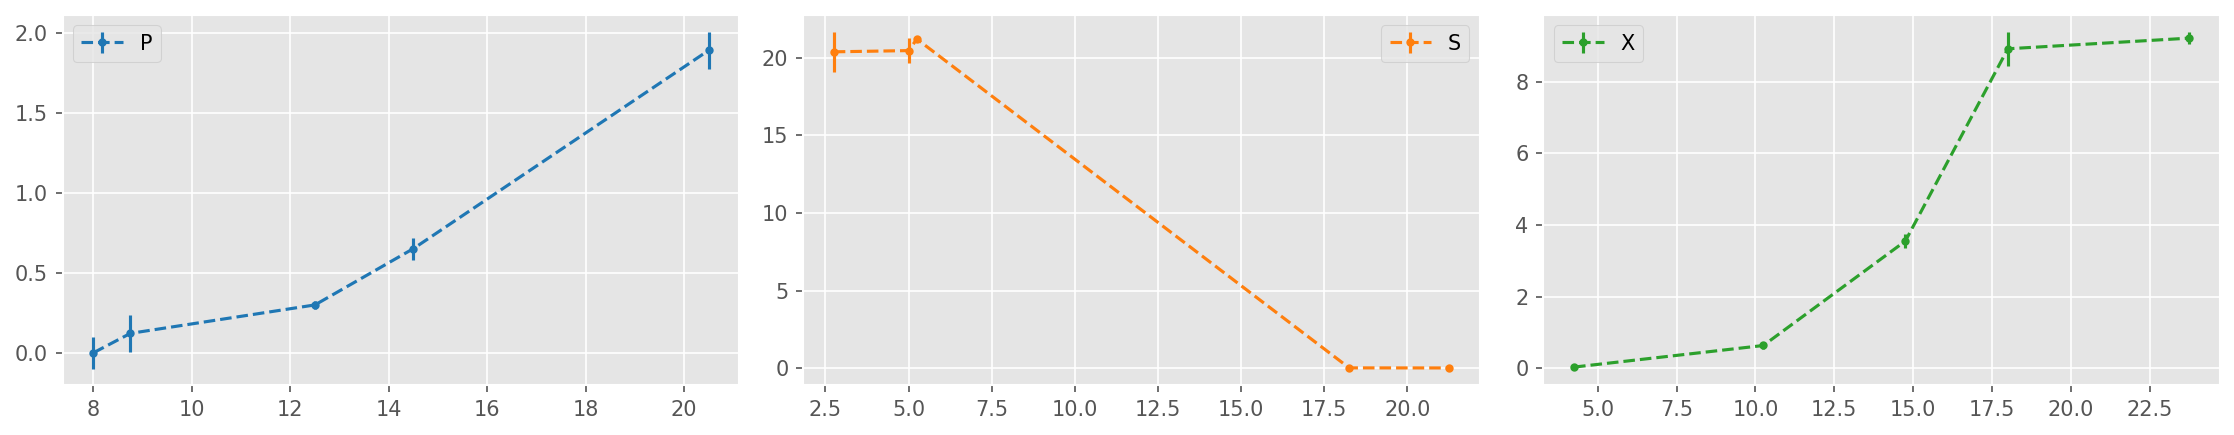

In [5]:
# Generates noisy artificial data from the simulation
data, simulation = make_experiment(caretaker, samples=5, tfinal=24)

# Parameter estimation
As usual, the `unknowns` and corresponding `bounds` have to specified for the estimation job.

In [6]:
# Defines the unknowns to be estimated, as well as corresponding bounds
unknowns = [
    'kS', 
    'mu_max', 
    'YXS', 
    'YPS', 
    'YPX',
    'S0',
]

bounds = [
    (0.01, 1.0),
    (0.1, 1.0),
    (0.1, 1.0),
    (0.1, 1.0),
    (0.1, 1.0),
    (17.5, 22.5),
]

Instead of running a single parameter estimation and approximate the corresponding estimate errors by FIM, another possibility is run many estimations from different realisations of the measurement data which are in this case though of as random numbers.

With a sufficently high number of re-sampled measurement data, the resulting empirical distributions of parameter estimations represent a non-linear error propagation from the measurement errors to the estimates.

In [7]:
# The convergence criterion for the parallel estimation.
# Will be less strict that the default one (which is 1e-6) to reduce runtime of this notebook
rtol = 1e-2

In [8]:
# Using default settings
mc_estimates = caretaker.estimate_parallel_MC_sampling(
    unknowns=unknowns,
    bounds=bounds,
    measurements=data, 
    rtol_islands=rtol,
    report_level=2,
)

------- Starting batch #1 for MC sample 1 to 3.
------- Starting batch #2 for MC sample 4 to 6.
------- Starting batch #3 for MC sample 7 to 9.
------- Starting batch #4 for MC sample 10 to 12.
------- Starting batch #5 for MC sample 13 to 15.
------- Starting batch #6 for MC sample 16 to 18.
------- Starting batch #7 for MC sample 19 to 21.
------- Starting batch #8 for MC sample 22 to 24.
------- Starting batch #9 for MC sample 25.

-----------------------------------------------
Total runtime was 3.69 min.
Convergence ratio was 100.0 %.


In [9]:
# To get more samples, just do another run and concatenate the results.
# This allows to easily run several batches of MC estimation procedures.
more_mc_estimates = caretaker.estimate_parallel_MC_sampling(
    unknowns=unknowns,
    bounds=bounds,
    measurements=data, 
    rtol_islands=rtol,
    report_level=1,
)

.........
-----------------------------------------------
Total runtime was 3.31 min.
Convergence ratio was 100.0 %.


In [10]:
# Get even more samples
# One can define several `jobs_to_save`, which repeatedly runs the estimation procedure and stores results to file
even_more_mc_estimates = caretaker.estimate_parallel_MC_sampling(
    unknowns=unknowns,
    bounds=bounds,
    measurements=data, 
    rtol_islands=rtol,
    report_level=1,
    jobs_to_save=2, # Triggers result storage to file
)

.........
-----------------------------------------------
Total runtime was 3.16 min.
Convergence ratio was 100.0 %.
Current memory usage is 33.70 %.
Saved results of job #1 to file: GrowthCoupledProduction_MC-sample-estimates_session-id-1533962_job-1.xlsx

.........
-----------------------------------------------
Total runtime was 3.45 min.
Convergence ratio was 100.0 %.
Current memory usage is 35.10 %.
Saved results of job #2 to file: GrowthCoupledProduction_MC-sample-estimates_session-id-1533962_job-2.xlsx



In [11]:
# Merge results 
# NOTE: Can also read previously stored results from file to pandas.DataFrame and merge them, as seen here
merged_estimates = pandas.concat(
    [
        mc_estimates,
        more_mc_estimates,
        even_more_mc_estimates,
    ], 
    ignore_index=True,
)

merged_estimates.describe()

,kS,mu_max,S0,YPS,YPX,YXS
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.658355,0.410933,21.361387,0.540026,0.204083,0.538710
std,0.318575,0.006505,0.105830,0.204376,0.011008,0.068012
min,0.010246,0.394938,21.019841,0.193234,0.177338,0.461998
25%,0.367746,0.405580,21.311381,0.364084,0.196521,0.492598
50%,0.720818,0.411486,21.368807,0.524396,0.204770,0.516920
75%,0.974799,0.415472,21.434506,0.697395,0.211786,0.566896
max,0.999781,0.423351,21.608875,0.959972,0.228554,0.825363


# Controlling the degree of parallelization per MC sample

Furthermore, the degree of parallelization for each batch can be specified by the `n_islands` argument explicitly, or implicity by a list of supported algorithms for the `optimizers` argument. For more information on this, see also the other notebooks. In addition, the `report_level` is increased

In [12]:
mc_est_multi = caretaker.estimate_parallel_MC_sampling(
    unknowns=unknowns,
    bounds=bounds,
    measurements=data, 
    optimizers=['de1220', 'compass_search', 'ihs'],
    mc_samples=50,
    rtol_islands=rtol,
    report_level=4,
)


------- Starting batch #1 for MC sample 1 to 4.
MC sample #4: convergence
MC sample #1: convergence
MC sample #2: convergence
MC sample #3: no convergence after max. evolutions (25).
Runtime for batch 1 was 1.19 min.

------- Starting batch #2 for MC sample 5 to 8.
MC sample #7: convergence
MC sample #5: convergence
MC sample #6: convergence
MC sample #8: convergence
Runtime for batch 2 was 0.97 min.

------- Starting batch #3 for MC sample 9 to 12.
MC sample #10: convergence
MC sample #9: convergence
MC sample #11: convergence
MC sample #12: no convergence after max. evolutions (25).
Runtime for batch 3 was 1.16 min.

------- Starting batch #4 for MC sample 13 to 16.
MC sample #13: convergence
MC sample #14: convergence
MC sample #16: convergence
MC sample #15: convergence
Runtime for batch 4 was 0.93 min.

------- Starting batch #5 for MC sample 17 to 20.
MC sample #19: convergence
MC sample #17: convergence
MC sample #18: convergence
MC sample #20: convergence
Runtime for batch 5 w

# Finally, compare the obtained parameter distributions to the "true" values

In [13]:
estimates = pandas.concat([merged_estimates, mc_est_multi], ignore_index=True)
estimates.describe()

,kS,mu_max,S0,YPS,YPX,YXS
count,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000
mean,0.657411,0.411170,21.353633,0.542023,0.204463,0.537269
std,0.373353,0.007429,0.103830,0.198963,0.010468,0.065281
min,0.010000,0.394938,21.019841,0.193234,0.177338,0.461998
25%,0.287543,0.405116,21.296932,0.372705,0.197585,0.492627
50%,0.812418,0.412196,21.360843,0.520173,0.205032,0.516920
75%,0.998970,0.416870,21.422780,0.692275,0.211542,0.564202
max,1.000000,0.423857,21.608875,0.959972,0.228554,0.825363


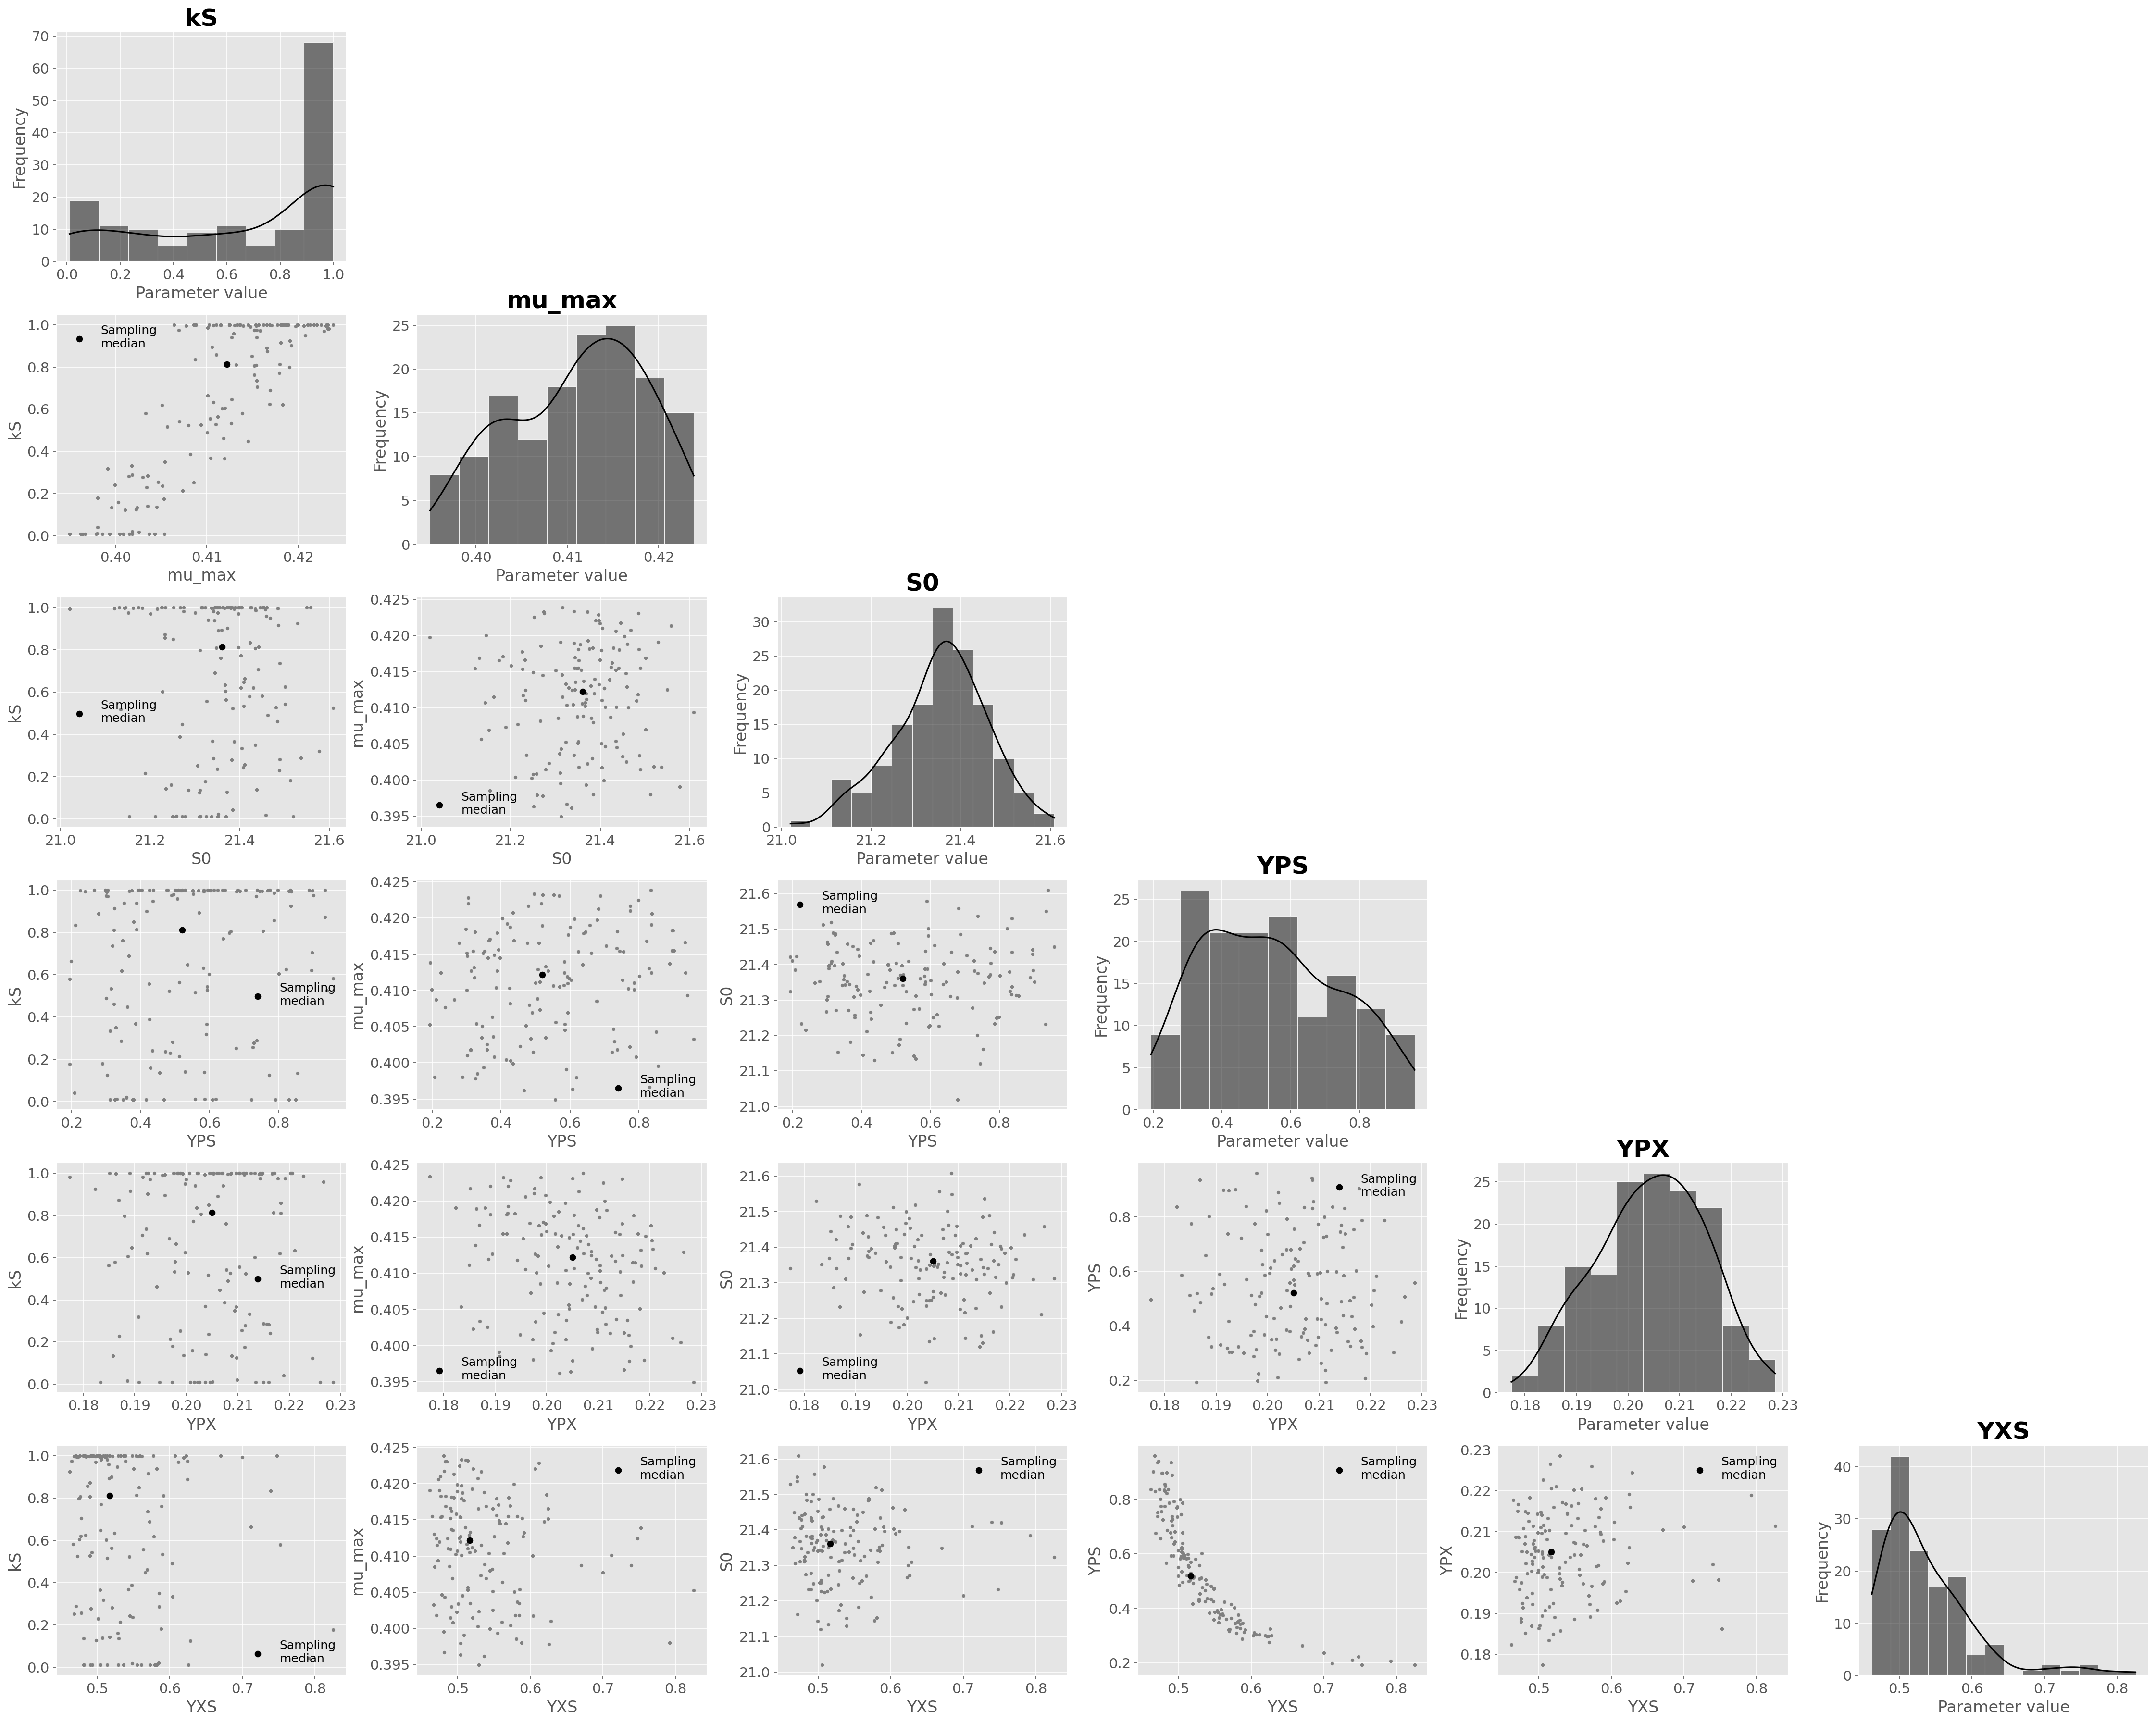

In [14]:
_ = Visualization.show_parameter_distributions(estimates)

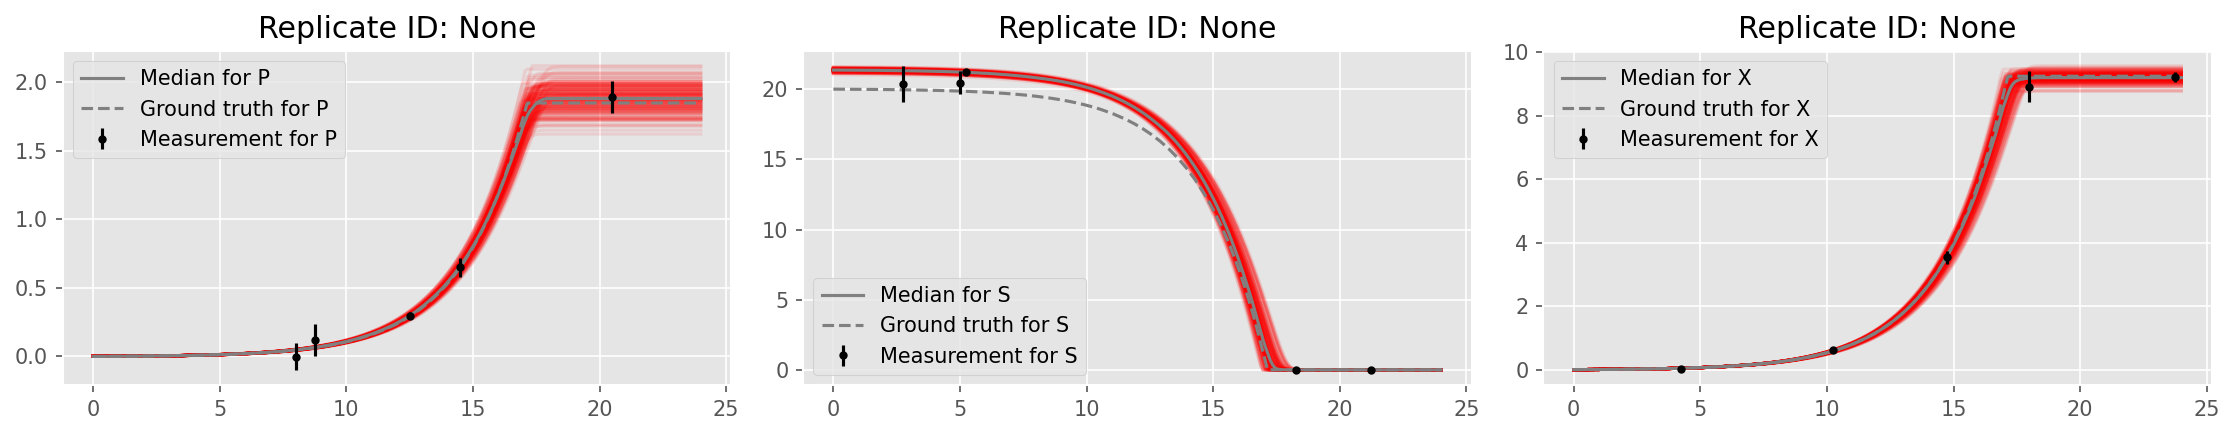

In [15]:
_ = Visualization.compare_estimates_many(
    parameter_collections=estimates, 
    measurements=data,
    caretaker=caretaker,
    truth=simulation,
)

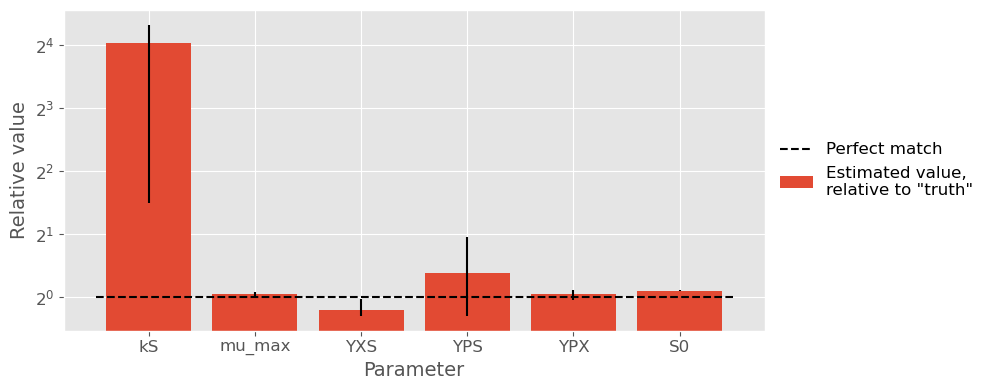

In [16]:
fig, ax = pyplot.subplots(dpi=100, figsize=(10, 4))
true_values = {_p : _pars_for_comp[_p] for _p in unknowns}
rel_values = {_p : numpy.median(estimates[_p])/true_values[_p] for _p in unknowns}
rel_values_lower = {_p : (numpy.median(estimates[_p])-numpy.quantile(estimates[_p], 0.16))/true_values[_p] for _p in unknowns}
rel_values_upper = {_p : (numpy.quantile(estimates[_p], 0.84)-numpy.median(estimates[_p]))/true_values[_p] for _p in unknowns}

ax.bar(
    true_values.keys(), 
    rel_values.values(), 
    yerr=[rel_values_lower.values(), rel_values_upper.values()], 
    label='Estimated value,\nrelative to "truth"',
)
ax.set_yscale('log', base=2)
_x = numpy.arange(len(unknowns))
_x = [_x[0]-0.5, *_x, _x[-1]+0.5]
ax.plot(_x, [1]*len(_x), linestyle='--', zorder=2, color='black', label='Perfect match')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, frameon=False)
ax.set_xlabel('Parameter', size=14)
ax.set_ylabel('Relative value', size=14)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
fig.tight_layout()